<a href="https://colab.research.google.com/github/werd0n4/hand-gesture-classification/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

---


In [14]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!ls

drive  sample_data


In [16]:
import pandas as pd
import numpy as np

import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import os
import cv2
import glob
import random
from matplotlib import pyplot as plt

# Constant parameters

---



In [17]:
horiz_x = 174
vert_y = 131
imgs_dir_path = '/content/drive/My Drive/Colab Notebooks/hgr1_original_images'

In [18]:
class_ids = {
    "1_P": 0, 
    "2_P": 1,
    "3_P": 2,
    "4_P": 3,
    "5_P": 4,
    "A_P": 5,
    "B_P": 6,
    "C_P": 7,
    "D_P": 8,
    "E_P": 9,
    "F_P": 10,
    "G_P": 11,
    "H_P": 12,
    "I_P": 13,
    "K_P": 14,
    "L_P": 15,
    "M_P": 16,
    "N_P": 17,
    "O_P": 18,
    "P_P": 19,
    "R_P": 20,
    "S_P": 21,
    "T_P": 22,
    "U_P": 23,
    "W_P": 24,
    "Y_P": 25,
    "Z_P": 26
}

class_names = {
    0: "Polish number one",
    1: "Polish number two",
    2: "Polish number three",
    3: "Polish number four",
    4: "Polish number five",
    5: "Polish letter A",
    6: "Polish letter B",
    7: "Polish letter C",
    8: "Polish letter D",
    9: "Polish letter E",
    10: "Polish letter F",
    11: "Polish letter G",
    12: "Polish letter H",
    13: "Polish letter I",
    14: "Polish letter K",
    15: "Polish letter L",
    16: "Polish letter M",
    17: "Polish letter N",
    18: "Polish letter O",
    19: "Polish letter P",
    20: "Polish letter R",
    21: "Polish letter S",
    22: "Polish letter T",
    23: "Polish letter U",
    24: "Polish letter W",
    25: "Polish letter Y",
    26: "Polish letter Z"
}

print(class_ids["1_P"])

0


# Auxiliary functions

---


In [19]:

def resize(path):
    img_counter = 0
    
    for filename in os.listdir(path):
        image_path = os.path.join(path, filename)
        # print(image_path)
        img = cv2.imread(image_path)
        resized_img = cv2.resize(img, (horiz_x, vert_y))
        cv2.imwrite(image_path, resized_img)
        img_counter += 1
    
    print('Images in set: ' + str(img_counter))


In [20]:

def sanity_check(path):
    counter = 0

    for filename in os.listdir(path):
        image_path = os.path.join(path, filename)
        img = cv2.imread(image_path)
        if img.shape != (horiz_x, vert_y, 3):
            counter += 1

    print('Sanity result: ' + str(counter))

In [21]:

def show_img(index, X, Y):
    # plt.imshow(X[index])
    plt.imshow(cv2.cvtColor(X[index],cv2.COLOR_BGR2RGB).astype('float32'))
    plt.show()
    nmb = int(np.where(Y[index] == 1)[0])
    print(class_names[nmb])

In [43]:

def count_classes():
    filelist = glob.glob(f'{imgs_dir_path}/*')
    classes_count = np.full((27), 0)
    for i,fname in enumerate(filelist):
        filename = fname.split('/')[-1]
        fileid = str(filename[:3])
        Y[i] = class_ids[fileid]
        classes_count[class_ids[fileid]] += 1

    return classes_count



## Load dataset

In [22]:

def load_dataset(path):
    filelist = glob.glob(f'{imgs_dir_path}/*')
    X = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in filelist] )

    # Y = np.array([np.zeros(27) for fname in filelist])
    Y = np.array([0 for fname in filelist])
    # classes_count = np.full((27), 0)
    for i,fname in enumerate(filelist):
        filename = fname.split('/')[-1]
        fileid = str(filename[:3])
        # print(fileid)
        # print(class_ids[fileid])
        # Y[i][class_ids[fileid]] = 1
        Y[i] = class_ids[fileid]
        # classes_count[class_ids[fileid]] += 1

    return X, Y

## Create network model

In [23]:

def create_model():
    model = Sequential()
    
    # CONVOLUTIONAL LAYER
    model.add(Conv2D(
        filters=6, 
        kernel_size=(5,5), 
        input_shape=(131, 174, 3), 
        activation='relu'
    ))

    # POOLING LAYER
    model.add(MaxPool2D(
        pool_size=(2,2),
        strides=(2,2)
    ))

    # CONVOLUTIONAL LAYER
    model.add(Conv2D(
        filters=16, 
        kernel_size=(5,5), 
        input_shape=(62, 84, 6), 
        activation='relu'
    ))

    # POOLING LAYER
    model.add(MaxPool2D(
        pool_size=(2,2),
        strides=(2,2)
    ))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(84, activation='relu'))
    model.add(Dense(27, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam', 
        metrics=['accuracy']
    )

    return model


# Loading dataset

---


In [24]:
### Uncomment if neccessary
# resize(imgs_dir_path)
# sanity_check(imgs_dir_path
###

In [25]:
X, Y = load_dataset(imgs_dir_path)

(899,)

In [44]:
classes_count = count_classes()

In [45]:
print(X.shape)
print(Y.shape)
print(classes_count)

(899, 131, 174, 3)
(899,)
[33 34 33 33 33 39 33 33 27 33 33 32 33 33 33 33 35 33 33 33 34 33 35 32
 36 33 34]


In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [27]:
# One hot encoding
Y_cat_train = to_categorical(Y_train)
Y_cat_test = to_categorical(Y_test)

# Create and train model

---


In [28]:
CNN = create_model()
CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 127, 170, 6)       456       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 85, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 59, 81, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 40, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18560)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2375808   
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

In [29]:
early_stop = EarlyStopping(monitor='val_loss', patience=1)

In [30]:
CNN.fit(X_train, Y_cat_train, epochs=26, validation_data=(X_test, Y_cat_test), callbacks=[early_stop])

Epoch 1/26
23/23 [==============================] - 1s 44ms/step - loss: 3.3977 - accuracy: 0.0501 - val_loss: 3.2898 - val_accuracy: 0.0333
Epoch 2/26
23/23 [==============================] - 1s 24ms/step - loss: 3.2182 - accuracy: 0.0695 - val_loss: 3.2192 - val_accuracy: 0.1000
Epoch 3/26
23/23 [==============================] - 1s 25ms/step - loss: 2.8590 - accuracy: 0.2017 - val_loss: 2.8434 - val_accuracy: 0.1111
Epoch 4/26
23/23 [==============================] - 1s 24ms/step - loss: 2.1846 - accuracy: 0.3727 - val_loss: 2.5953 - val_accuracy: 0.1500
Epoch 5/26
23/23 [==============================] - 1s 25ms/step - loss: 1.6131 - accuracy: 0.5396 - val_loss: 2.6611 - val_accuracy: 0.2278


# Results

---


In [31]:
metrics = pd.DataFrame(CNN.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,3.397697,0.050070,3.289772,0.033333
1,3.218233,0.069541,3.219246,0.100000
2,2.858956,0.201669,2.843434,0.111111
3,2.184644,0.372740,2.595311,0.150000
4,1.613137,0.539638,2.661090,0.227778


## Single image prediction

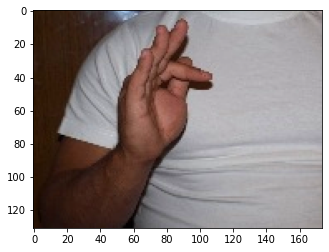

Polish letter F


In [32]:
my_hand = X_test[0]
show_img(0, X_test, Y_cat_test)

In [33]:
my_hand = my_hand.reshape(1, 131, 174, 3)
result = CNN.predict_classes(my_hand)
result = int(result)
print('CNN says: ' + class_names[result])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
CNN says: Polish letter G


## Predictions for individual classes

In [34]:
predictions = CNN.predict_classes(X_test)

In [35]:
print(classification_report(Y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           1       0.33      0.20      0.25         5
           2       0.00      0.00      0.00         5
           3       0.43      0.75      0.55         8
           4       0.50      0.20      0.29         5
           5       0.17      0.80      0.29         5
           6       1.00      0.29      0.44         7
           7       0.33      0.14      0.20         7
           8       0.33      0.12      0.18         8
           9       1.00      0.17      0.29         6
          10       0.00      0.00      0.00         6
          11       0.18      0.50      0.27         8
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         5
          14       1.00      0.12      0.22         8
          15       0.50      0.38      0.43         8
          16       0.00      0.00      0.00         6
          17       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
